In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config, make_date_key_str
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb, log_mlflow
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml
import wandb

In [ ]:
predictions_dict = {}

In [27]:
config_filename = 'default.yaml'
config = read_config(config_filename)

wandb_config = read_config(config_filename, preprocess=False)
wandb_config = make_date_key_str(wandb_config)

In [ ]:
timestamp = datetime.datetime.now()
output_folder = '../../misc/reports/{}'.format(timestamp.strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

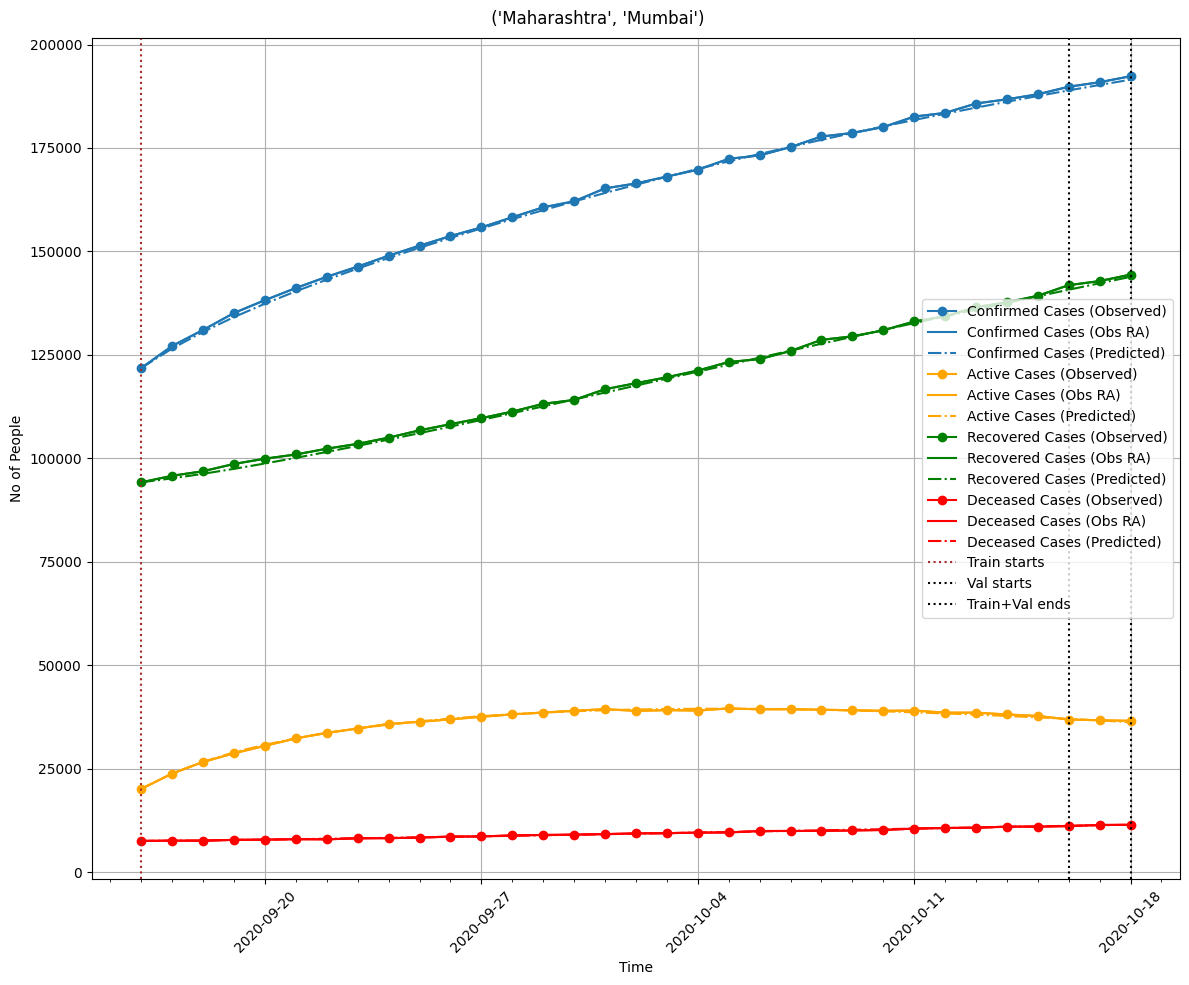

In [25]:
import pickle as pkl
with open('../../misc/predictions/exp_set0.pickle', 'rb') as handle:
    predictions_dict = pkl.load(handle)

In [28]:
%%time
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting']))

Performing m1 fit ..
parameters used to generate data: {'lockdown_R0': 0.8, 'T_inc': 5.1, 'T_inf': 3.6, 'T_recov': 21.5, 'T_recov_fatal': 25.5, 'P_fatal': 0.08, 'E_hosp_ratio': 0.34, 'I_hosp_ratio': 0.94}
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 4                   | 5                   | 6                   | 7                   | 8                   |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-09-20 00:00:00 | 2020-09-21 00:00:00 | 2020-09-22 00:00:00 | 2020-09-23 00:00:00 | 2020-09-24 00:00:00 |
| active      | 30033.71            | 31748.71            | 33656.0             | 34678.0             | 35804.0             |
| total       | 137553.43           | 140668.14           | 143865.0            | 146332.0            | 148963.0          

IndexError: single positional indexer is out-of-bounds

{}

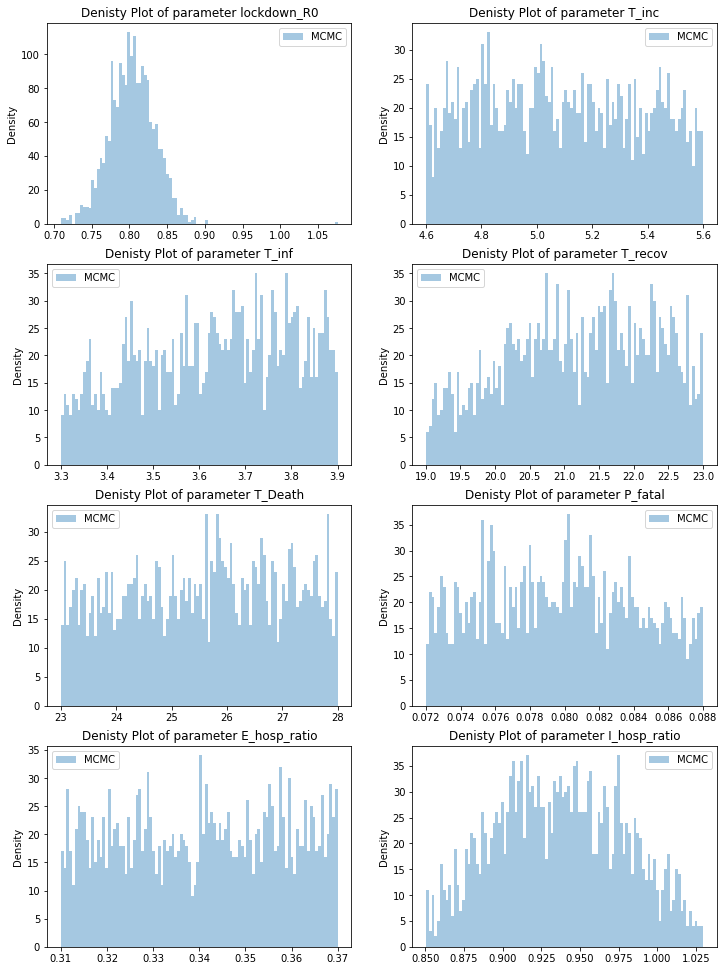

In [29]:
figs, axs = plt.subplots(4,2,figsize = [12,17])
from viz.fit import plot_histogram
true_val  = {"lockdown_R0": 0.8,
    "T_inc": 5.1,
    "T_inf": 3.6,
    "T_recov": 21.5,
    "T_recov_fatal": 25.5 ,
    "P_fatal": 0.08,
    "E_hosp_ratio": 0.34,
    "I_hosp_ratio": 0.94}
plot_histogram(predictions_dict['m1'],true_val,figs,axs)

In [ ]:
m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = timestamp.strftime("%Y-%m-%d")

In [ ]:
predictions_dict['m1']['best_params']

In [ ]:
predictions_dict['m2']['best_params']

## Loss Dataframes

### M1 Loss DataFrame

In [ ]:
np.mean(predictions_dict['m1']['df_loss']['train'])

### M2 Loss DataFrame

In [ ]:
predictions_dict['m2']['df_loss']

## Sensitivity Plot

In [ ]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [ ]:
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 'test', 
                                                                 error_bars=False)

predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])
                               
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [ ]:
config = read_config(config_filename)

In [ ]:
uncertainty_args = {'predictions_dict': predictions_dict, 'fitting_config': config['fitting'],
                    'forecast_config': config['forecast'], **config['uncertainty']['uncertainty_params']}
                    
uncertainty = config['uncertainty']['method'](**uncertainty_args)

In [ ]:
uncertainty.ensemble_mean_forecast['df_loss']

In [ ]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [ ]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

In [ ]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 48.7804878], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80.48780488], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 48.7804878], error_bars=False)

In [ ]:
config['forecast']['plot_ptiles_for_columns']

In [ ]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## Create Report

In [ ]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output CSV

In [ ]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

## Log on W&B

In [ ]:
wandb.init(project="covid-modelling", config=wandb_config)

In [ ]:
log_wandb(predictions_dict)

## Create All Trials Output

In [ ]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Log on MLFlow

In [ ]:
a = {1:[2,3],2:[3,4],3:[4,5]}
b = {1:[4,5],2:[5,6],3:[7,8]}

In [ ]:
a.update(b)

In [ ]:
a


In [ ]:
log_mlflow(config['logging']['experiment_name'], run_name=config['logging']['run_name'], artifact_dir=output_folder)